# Churn Prediction & Revenue-at-Risk — Analytical Report

---

## Imports & Setup

In [1]:
# -------------------------
# Imports
# -------------------------
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix, RocCurveDisplay
)

from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")

# -------------------------
# Resolve project root
# Notebook is in /src/ml/, so root is 2 directories up
# -------------------------
BASE_DIR = Path.cwd().parents[1]

DUCKDB_PATH = BASE_DIR / "finance.duckdb"
PROCESSED_PATH = BASE_DIR / "data" / "processed"
PROCESSED_PATH.mkdir(parents=True, exist_ok=True)

DUCKDB_PATH, PROCESSED_PATH

(PosixPath('/Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/enterprise-financial-kpi-platform/finance.duckdb'),
 PosixPath('/Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/enterprise-financial-kpi-platform/data/processed'))

## Load Customer Features from DuckDB

In [2]:
con = duckdb.connect(str(DUCKDB_PATH))

df = con.execute("""
WITH activity AS (
    SELECT
        customer_id,
        COUNT(DISTINCT year_month_key) AS active_months,
        SUM(revenue) AS total_revenue,
        AVG(revenue) AS avg_monthly_revenue,
        MAX(revenue) AS max_monthly_revenue,
        SUM(num_transactions) AS total_transactions,
        AVG(num_transactions) AS avg_tx_per_month
    FROM vw_customer_activity_monthly
    GROUP BY customer_id
)
SELECT
    c.customer_id,
    c.segment,
    c.region,
    c.risk_score,
    c.acquisition_date,
    c.churn_date,
    c.is_active,
    COALESCE(a.active_months, 0) AS active_months,
    COALESCE(a.total_revenue, 0) AS total_revenue,
    COALESCE(a.avg_monthly_revenue, 0) AS avg_monthly_revenue,
    COALESCE(a.max_monthly_revenue, 0) AS max_monthly_revenue,
    COALESCE(a.total_transactions, 0) AS total_transactions,
    COALESCE(a.avg_tx_per_month, 0) AS avg_tx_per_month
FROM dim_customer c
LEFT JOIN activity a USING(customer_id)
""").fetchdf()

con.close()

# Convert date columns
df["acquisition_date"] = pd.to_datetime(df["acquisition_date"])
df["churn_date"] = pd.to_datetime(df["churn_date"])

df.head()

,customer_id,segment,region,risk_score,acquisition_date,churn_date,is_active,active_months,total_revenue,avg_monthly_revenue,max_monthly_revenue,total_transactions,avg_tx_per_month
0,1,SME,North,589.87,2022-04-28,NaT,1,31,79801.88,2574.254194,11338.09,66.0,2.129032
1,2,Retail,West,451.09,2021-04-26,2022-05-01,0,2,531.94,265.970000,416.43,2.0,1.000000
2,3,SME,International,394.35,2022-07-30,2023-10-01,0,15,32461.53,2164.102000,9028.05,24.0,1.600000
3,4,SME,East,691.83,2022-02-03,2022-10-01,0,8,29460.90,3682.612500,12600.32,17.0,2.125000
4,5,Retail,North,525.97,2020-04-13,NaT,1,22,11279.79,512.717727,3000.68,27.0,1.227273


## Compute Tenure + Label

In [3]:
# Compute tenure using safe timedelta logic
dataset_end = max(df["acquisition_date"].max(), df["churn_date"].max())

delta_churn = (df["churn_date"] - df["acquisition_date"]).astype("timedelta64[ns]")
delta_end = (dataset_end - df["acquisition_date"]).astype("timedelta64[ns]")

df["tenure_days"] = np.where(
    df["churn_date"].notna(),
    delta_churn / np.timedelta64(1, "D"),
    delta_end  / np.timedelta64(1, "D")
).astype(int)

df["churn_label"] = (df["is_active"] == 0).astype(int)

df.head()

,customer_id,segment,region,risk_score,acquisition_date,churn_date,is_active,active_months,total_revenue,avg_monthly_revenue,max_monthly_revenue,total_transactions,avg_tx_per_month,tenure_days,churn_label
0,1,SME,North,589.87,2022-04-28,NaT,1,31,79801.88,2574.254194,11338.09,66.0,2.129032,948,0
1,2,Retail,West,451.09,2021-04-26,2022-05-01,0,2,531.94,265.970000,416.43,2.0,1.000000,370,1
2,3,SME,International,394.35,2022-07-30,2023-10-01,0,15,32461.53,2164.102000,9028.05,24.0,1.600000,428,1
3,4,SME,East,691.83,2022-02-03,2022-10-01,0,8,29460.90,3682.612500,12600.32,17.0,2.125000,240,1
4,5,Retail,North,525.97,2020-04-13,NaT,1,22,11279.79,512.717727,3000.68,27.0,1.227273,1693,0


## Basic Data Profiling

In [4]:
print("Dataset shape:", df.shape)
df.info()
df.isna().sum()

Dataset shape: (3000, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          3000 non-null   int32         
 1   segment              3000 non-null   object        
 2   region               3000 non-null   object        
 3   risk_score           3000 non-null   float64       
 4   acquisition_date     3000 non-null   datetime64[us]
 5   churn_date           984 non-null    datetime64[us]
 6   is_active            3000 non-null   int32         
 7   active_months        3000 non-null   int64         
 8   total_revenue        3000 non-null   float64       
 9   avg_monthly_revenue  3000 non-null   float64       
 10  max_monthly_revenue  3000 non-null   float64       
 11  total_transactions   3000 non-null   float64       
 12  avg_tx_per_month     3000 non-null   float64       
 13  tenure_

customer_id               0
segment                   0
region                    0
risk_score                0
acquisition_date          0
churn_date             2016
is_active                 0
active_months             0
total_revenue             0
avg_monthly_revenue       0
max_monthly_revenue       0
total_transactions        0
avg_tx_per_month          0
tenure_days               0
churn_label               0
dtype: int64

## Distribution Plots

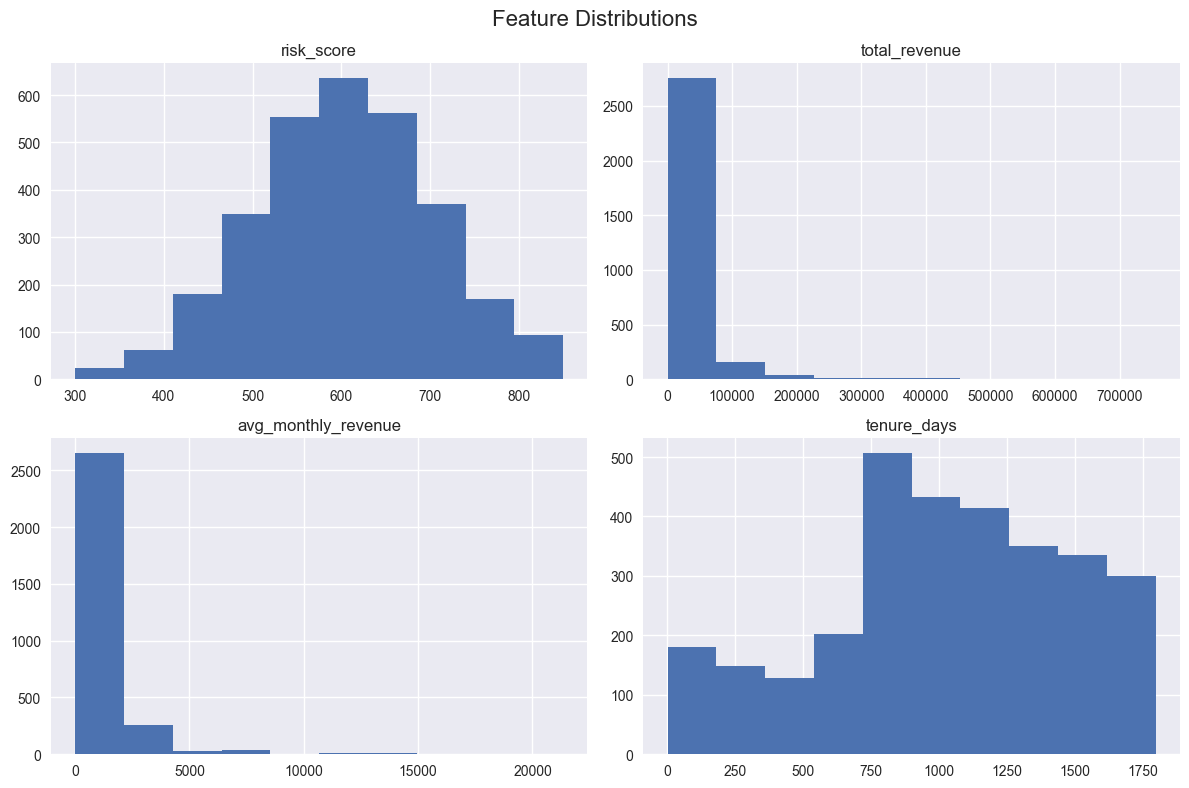

In [5]:
df[["risk_score", "total_revenue", "avg_monthly_revenue", "tenure_days"]].hist(figsize=(12, 8))
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

## Model Pipeline Setup

In [6]:
numeric_features = [
    "risk_score",
    "active_months",
    "total_revenue",
    "avg_monthly_revenue",
    "max_monthly_revenue",
    "total_transactions",
    "avg_tx_per_month",
    "tenure_days",
]

categorical_features = ["segment", "region"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

clf = Pipeline([
    ("preprocess", preprocessor),
    ("model", model)
])

## Train / Test Split + Model Training

In [7]:
X = df[numeric_features + categorical_features]
y = df["churn_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

ROC-AUC: 0.8250419408955993
Accuracy: 0.8733333333333333
[[498   6]
 [ 89 157]]


## ROC Curve

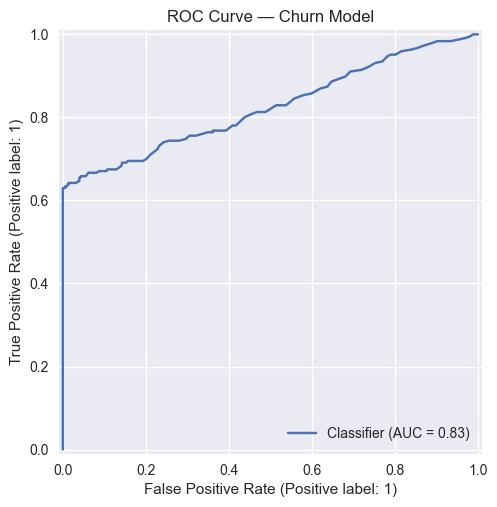

In [8]:
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve — Churn Model")
plt.show()

## Feature Importance

In [9]:
importances = clf.named_steps["model"].feature_importances_
feature_names = clf.named_steps["preprocess"].get_feature_names_out()

fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})

fi.sort_values("importance", ascending=False).head(15)

,feature,importance
7,num__tenure_days,0.376837
1,num__active_months,0.125894
2,num__total_revenue,0.084463
5,num__total_transactions,0.079568
3,num__avg_monthly_revenue,0.078527
4,num__max_monthly_revenue,0.072505
0,num__risk_score,0.065161
6,num__avg_tx_per_month,0.057924
9,cat__segment_Retail,0.008663
12,cat__region_East,0.007979


## Add Predicted Probabilities + Risk Bands

In [10]:
clf.fit(X, y)  # final model on full dataset

df["churn_probability"] = clf.predict_proba(X)[:, 1]

df["churn_probability_band"] = pd.cut(
    df["churn_probability"],
    bins=[0, 0.30, 0.70, 1.0],
    labels=["Low (0–30%)", "Medium (30–70%)", "High (70–100%)"],
    include_lowest=True,
)

df.head()

,customer_id,segment,region,risk_score,acquisition_date,churn_date,is_active,active_months,total_revenue,avg_monthly_revenue,max_monthly_revenue,total_transactions,avg_tx_per_month,tenure_days,churn_label,churn_probability,churn_probability_band
0,1,SME,North,589.87,2022-04-28,NaT,1,31,79801.88,2574.254194,11338.09,66.0,2.129032,948,0,0.055,Low (0–30%)
1,2,Retail,West,451.09,2021-04-26,2022-05-01,0,2,531.94,265.970000,416.43,2.0,1.000000,370,1,0.995,High (70–100%)
2,3,SME,International,394.35,2022-07-30,2023-10-01,0,15,32461.53,2164.102000,9028.05,24.0,1.600000,428,1,0.980,High (70–100%)
3,4,SME,East,691.83,2022-02-03,2022-10-01,0,8,29460.90,3682.612500,12600.32,17.0,2.125000,240,1,1.000,High (70–100%)
4,5,Retail,North,525.97,2020-04-13,NaT,1,22,11279.79,512.717727,3000.68,27.0,1.227273,1693,0,0.025,Low (0–30%)


## Churn Probability Distribution Plot

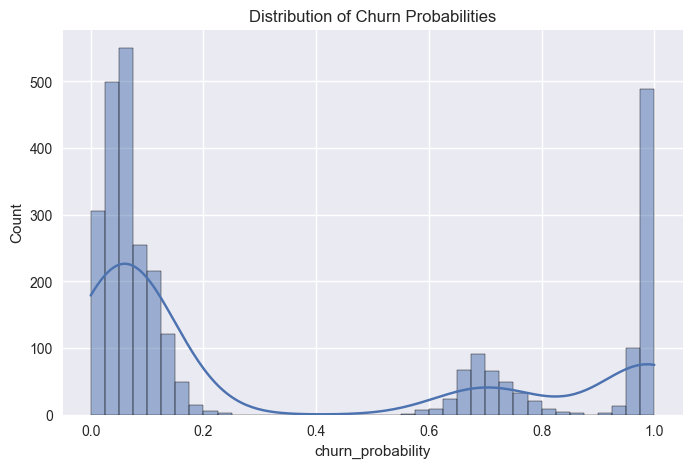

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="churn_probability", bins=40, kde=True)
plt.title("Distribution of Churn Probabilities")
plt.show()

## Segment & Region Risk Analysis

In [12]:
seg = df.groupby("segment")["churn_probability"].mean().sort_values()
reg = df.groupby("region")["churn_probability"].mean().sort_values()

print(seg)
print(reg)

segment
Corporate    0.302864
SME          0.318202
Retail       0.343725
Name: churn_probability, dtype: float64
region
South            0.303779
International    0.319250
North            0.327121
West             0.329232
Central          0.345032
East             0.371842
Name: churn_probability, dtype: float64


## Revenue at Risk Calculation

In [13]:
# Pull aggregated revenue directly from warehouse
con = duckdb.connect(str(DUCKDB_PATH))
rev = con.execute("""
    SELECT customer_id, SUM(revenue) AS revenue_from_activity
    FROM vw_customer_activity_monthly
    GROUP BY customer_id
""").fetchdf()
con.close()

merged = df.merge(rev, on="customer_id", how="left")

high_risk = merged[merged["churn_probability"] >= 0.7]

total_revenue = merged["revenue_from_activity"].sum()
revenue_at_risk = high_risk["revenue_from_activity"].sum()

print("High-risk customers:", len(high_risk))
print("Revenue at risk:", revenue_at_risk)
print("Share of total revenue:", revenue_at_risk / total_revenue)

High-risk customers: 800
Revenue at risk: 10602775.11
Share of total revenue: 0.13009647539002195


## Save Notebook Output

In [14]:
pred = df[[
    "customer_id",
    "churn_label",
    "churn_probability",
    "churn_probability_band"
]].copy()

pred["run_date"] = pd.Timestamp.today().date().isoformat()

pred_csv = PROCESSED_PATH / "predicted_churn_notebook.csv"
pred.to_csv(pred_csv, index=False)

pred.head()

,customer_id,churn_label,churn_probability,churn_probability_band,run_date
0,1,0,0.055,Low (0–30%),2025-12-03
1,2,1,0.995,High (70–100%),2025-12-03
2,3,1,0.980,High (70–100%),2025-12-03
3,4,1,1.000,High (70–100%),2025-12-03
4,5,0,0.025,Low (0–30%),2025-12-03
